# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


### Part 3.3 BiGru Model

The weight matrix will be created by BatchIterator class  based on the Glove word vectors we want to use and vocabularly word2index dictionary. For each word, index pair from word2index, the weight matrix at the position equals index will be set with the Glove vector that represents given word. 

For words that haven't been found in the Glove mapping, the random vector will be initialised. Then the weight matrix will be passed to the embedding layer as its parameters. 

It is very important to set the embedding_layer.weight.requires_grad = False, so that weights will not be updated during the training. After the GRU layer, extra features will be concatenated toehter with max-pooled, avg-pooled and last hidden size. The concatenated tensor will be next passed to the linear layer, so we have to set the input size to hidden_size * 3 + num_features.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from common_utils import UNK_TOKEN,EMBEDDING_DIM,SAVE_DIR,VOCAB_PATH,EMBEDDING_MATRIX_PATH,WORD2IDX_PATH,IDX2WORD_PATH,tokenize, EmbeddingMatrix, CustomDatasetPreparer, set_seed
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
set_seed(42)

In [2]:
# Load Dataset using CustomDatasetPreparer

BATCH_SIZE = 64
dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [3]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()
word_embeddings.unk_idx

16164

In [4]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size

        # Linear transformations for Q, K, V from the same source
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        # Apply linear transformations
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply weights with values
        output = torch.matmul(attention_weights, values)

        return output, attention_weights


In [5]:
class BiLSTMGRU(nn.Module):
    """
    BiDirectional LSTM/GRU neural network model with pre-trained word embeddings.

    Parameters
    -----------
    hidden_size: int 
        Number of features in the hidden state
    weight_matrix: numpy.ndarray 
        Matrix of pre-trained word embeddings (word_embedding)
    output_size: int
        Number of classes 
    n_layer: int, optional (default=1)
        Number of stacked recurrent layers. 
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout. 
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU. 
    GRU: boolean, optional (default=True)
        Whether to use GRU or LSTM. 
    """

    def __init__(self, hidden_size, weights_matrix: EmbeddingMatrix, output_size, n_layers=1, dropout=0.2, spatial_dropout=True, bidirectional=True, attention = False,  GRU = True):

        # Inherit everything from the nn.Module
        super(BiLSTMGRU, self).__init__()

        # Initialise attributes
        self.hidden_size = hidden_size
        self.weights_matrix = weights_matrix
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        self.use_attention = attention
        self.use_gru = GRU

        self.embedding_dim = self.weights_matrix.dimension

        # Embedding layer - Convert words into vectors of numbers that capture their meaning from pretrained word embeddings.
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(self.weights_matrix.embedding_matrix, dtype=torch.float), freeze=False)

        # Define dropout layers - Randomly set some neurons to zero during training to prevent overfitting
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout1d(self.dropout_p)

        # Define GRU / LSTM layer
        if self.use_gru:
            self.main = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True, bidirectional=self.bidirectional)
        else:
            self.main = nn.LSTM(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True, bidirectional=self.bidirectional)
        
        if self.use_attention:
            self.self_attention = SelfAttentionLayer(self.hidden_size * 2)

        # Linear layer input size is equal to hidden_size * (4 with attention / 3 without), becuase
        # we are concatenating max_pooling ,avg_pooling, (2 * self Attn / last_hidden) and additional features
        self.linear = nn.Linear(self.hidden_size * (4 if self.use_attention else 3), self.output_size)

    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract input_size (Batch size)
        self.input_size = input_seq.size(0)
        #check if word is unknown and not in vocab, replace with unk_idx
        GetIdxOrUnk = lambda x: x if self.weights_matrix.idx2word.get(str(x), None) else self.weights_matrix.unk_idx
        input_seq.apply_(lambda x: GetIdxOrUnk(x)) 

        # Embeddings shapes of input
        # Input: (input_size,  seq_length)
        # Output: (input_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)

        # Pass the emebedding layer to the dropout layer
        if self.spatial_dropout:
            # Convert to (input_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            # Dropout1d layer
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (input_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)

        else:
            emb_out = self.dropout(emb_out)

        # Pack padded batch of sequences for RNN module
        # Removes the padding and concatenates the sequences along the time dimension
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through the GRU Layer
        if self.use_gru:
            main_out, hidden = self.main(packed_emb, hidden)
        else:
            main_out, (hidden, cell_state) = self.main(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # hidden (h_n) comprises the hidden states after the entire sequence

        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, input_size, hidden_size)
        # Separate hidden state layers
        # Process the hidden layer
        hidden = hidden.view(self.n_layers, self.n_directions, self.input_size, self.hidden_size)
        last_hidden = hidden[-1]

        # Since Bidirectional: Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)

        # Pad a packed batch
        main_out, lengths = nn.utils.rnn.pad_packed_sequence(main_out, batch_first=True)

        if self.use_attention:
            # Self-attention layer
            attention_output, attention_weights = self.self_attention(main_out)
            # Mean Pooling of self-attention to reduce dimensions
            attention_output_mean = torch.mean(attention_output, dim=1)

        # print(last_hidden.shape)
        # print(attention_output.shape)
        # print(attention_output_mean.shape)
        # Combine the GRU outputs
        if self.bidirectional:
            main_out = main_out[:, :, :self.hidden_size] + main_out[:, :, self.hidden_size:]

        # Get Max and Average Pooling

        # Select the maximum value over each dimension of the hidden representation (max pooling)
        max_pool = F.adaptive_max_pool1d(main_out.permute(0, 2, 1), (1,)).view(self.input_size, -1)

        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (input_size, hidden_size)
        avg_pool = torch.sum(main_out, dim=1) / lengths.view(-1, 1).type(torch.FloatTensor)

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor (Combining all features)
        concat_out = torch.cat([attention_output_mean if self.use_attention else last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # Pass through the linear layer and apply Softmax layer
        out = self.linear(concat_out)
        return out


In [6]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 40 
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.train()
    best_val_loss = np.inf
    patience = 3  # Number of epochs to wait before stopping
    trigger_times = 0

    for epoch in range(num_epochs):
        total_loss = 0
        correct_preds = 0
        total_samples = 0
        for batch in train_loader:
            sequences, features, lengths, labels = batch

            # Move tensors to device (GPU or CPU)
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            set_seed(42) # https://datascience.stackexchange.com/a/56615 bug?
            # Forward pass
            outputs = model(sequences, features, lengths)
            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping (for example, clipping the gradients' norm at 3.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early Stopping at {epoch+1}')
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct_pred = 0
    total_samples = 0

    with torch.no_grad():
        set_seed(42)
        for batch in data_loader:
            sequences, features, lengths, labels = batch

            # Move tensors to device
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            outputs = model(sequences, features, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_pred += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_pred / total_samples
    # print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy


In [8]:
import matplotlib.pyplot as plt

def run_model(model):
    print(model)

    # Create loss function
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model = model.to(device)

    EPOCHS = 40
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler)
    evaluate(model, val_loader, criterion)
    evaluate(model, test_loader, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
        
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

    return test_loss, test_accuracy 

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.7079, Train Accuracy: 0.5273, Val Loss: 0.6695, Val Accuracy: 0.6023
Epoch [2/40], Train Loss: 0.5986, Train Accuracy: 0.7023, Val Loss: 0.5424, Val Accuracy: 0.7411
Epoch [3/40], Train Loss: 0.4039, Train Accuracy: 0.8171, Val Loss: 0.4696, Val Accuracy: 0.7767
Epoch [4/40], Train Loss: 0.2584, Train Accuracy: 0.9021, Val Loss: 0.4697, Val Accuracy: 0.7767
Epoch [5/40], Train Loss: 0.2404, Train Accuracy: 0.9093, Val Loss: 0.4722, Val Accuracy: 0.7777
Early Stopping at 6
Test Loss: 0.4315, Test Accuracy: 0.8011


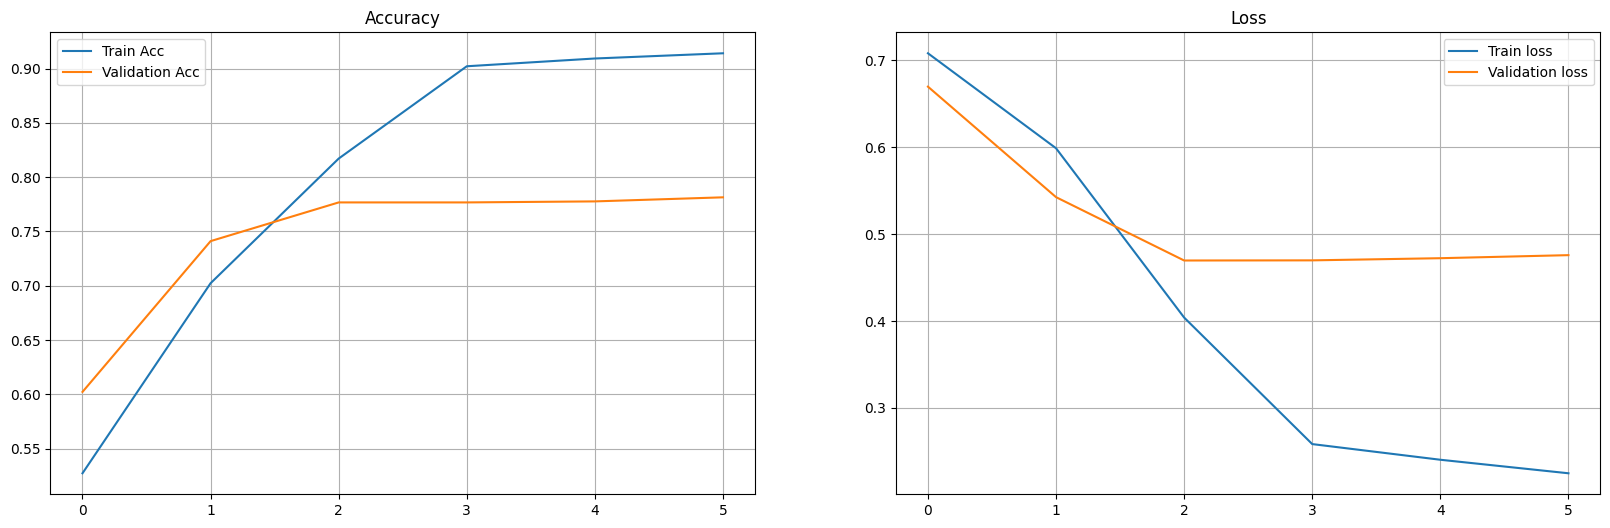

In [9]:
bigru_loss, bigru_accuracy = run_model(BiGruModel) # GRU no attention

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (self_attention): SelfAttentionLayer(
    (key): Linear(in_features=16, out_features=16, bias=True)
    (query): Linear(in_features=16, out_features=16, bias=True)
    (value): Linear(in_features=16, out_features=16, bias=True)
  )
  (linear): Linear(in_features=32, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.6897, Train Accuracy: 0.5427, Val Loss: 0.6732, Val Accuracy: 0.5966
Epoch [2/40], Train Loss: 0.6187, Train Accuracy: 0.6778, Val Loss: 0.5782, Val Accuracy: 0.7176
Epoch [3/40], Train Loss: 0.4347, Train Accuracy: 0.8061, Val Loss: 0.4911, Val Accuracy: 0.7645
Epoch [4/40], Train Loss: 0.2719, Train Accuracy: 0.8945, Val Loss: 0.4942, Val Accuracy: 0.7674
Epoch [5/40], Train Loss: 0.2513, Train Accuracy: 0.9033, Val Loss: 0.5010, Val Accuracy: 0.7692
Early Stopp

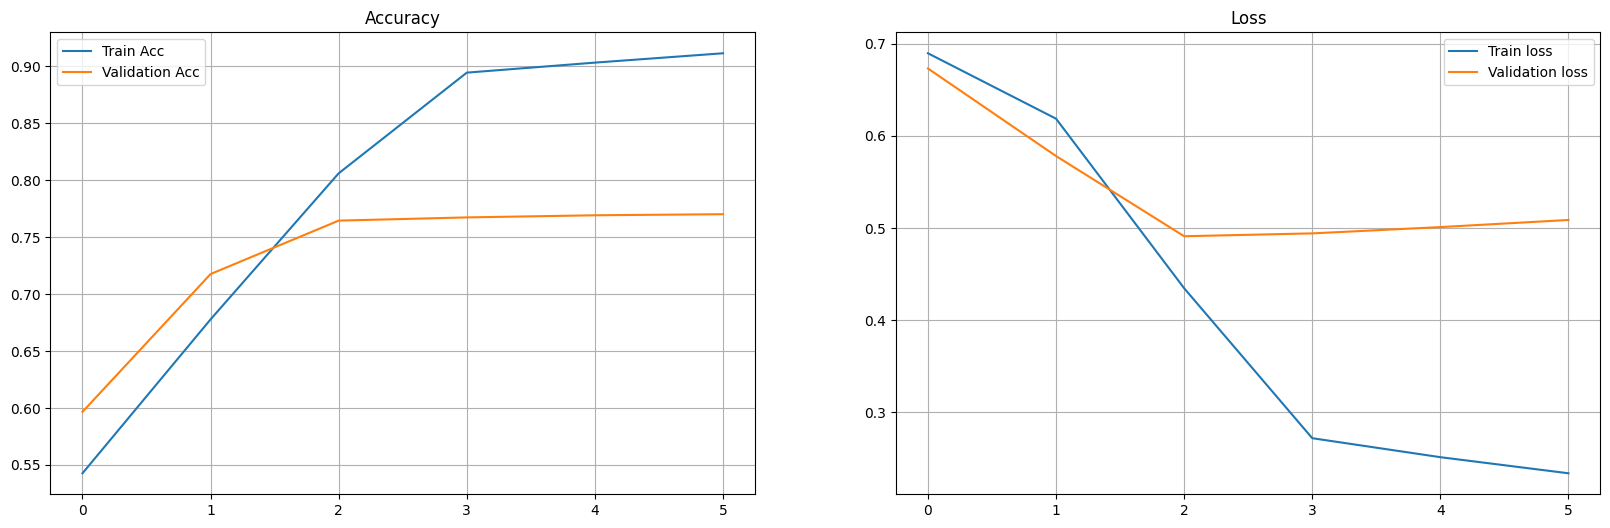

In [19]:
biGRU_w_attention = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=True, GRU=True)
biGRU_w_attention_loss, biGRU_w_attention_accuracy = run_model(biGRU_w_attention) # GRU attention

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): LSTM(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.6894, Train Accuracy: 0.5353, Val Loss: 0.6749, Val Accuracy: 0.5938
Epoch [2/40], Train Loss: 0.6050, Train Accuracy: 0.6838, Val Loss: 0.5470, Val Accuracy: 0.7101
Epoch [3/40], Train Loss: 0.4096, Train Accuracy: 0.8127, Val Loss: 0.4964, Val Accuracy: 0.7598
Epoch [4/40], Train Loss: 0.2583, Train Accuracy: 0.9011, Val Loss: 0.5059, Val Accuracy: 0.7702
Epoch [5/40], Train Loss: 0.2408, Train Accuracy: 0.9093, Val Loss: 0.5113, Val Accuracy: 0.7692
Early Stopping at 6
Test Loss: 0.5066, Test Accuracy: 0.7608


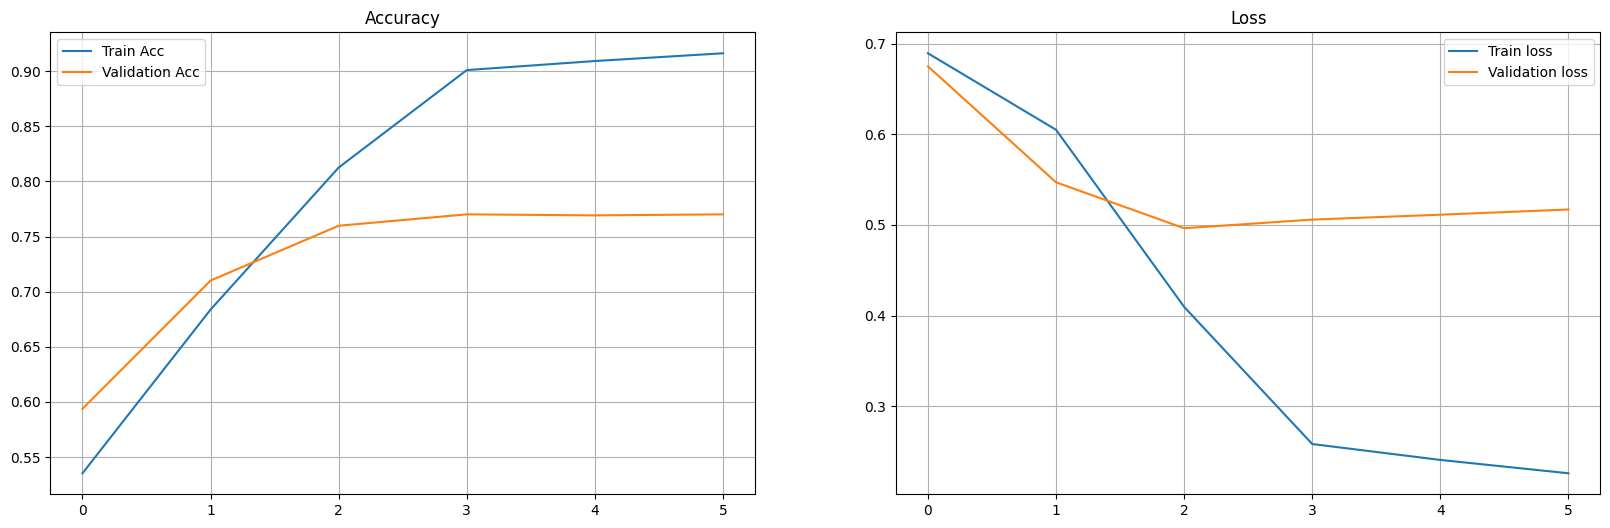

In [10]:
BiLSTM = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=False)
bilstm_loss, bilstm_accuracy = run_model(BiLSTM)

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): LSTM(100, 8, batch_first=True, bidirectional=True)
  (self_attention): SelfAttentionLayer(
    (key): Linear(in_features=16, out_features=16, bias=True)
    (query): Linear(in_features=16, out_features=16, bias=True)
    (value): Linear(in_features=16, out_features=16, bias=True)
  )
  (linear): Linear(in_features=32, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.6918, Train Accuracy: 0.5197, Val Loss: 0.6825, Val Accuracy: 0.5666
Epoch [2/40], Train Loss: 0.6050, Train Accuracy: 0.6790, Val Loss: 0.5405, Val Accuracy: 0.7261
Epoch [3/40], Train Loss: 0.3941, Train Accuracy: 0.8275, Val Loss: 0.5001, Val Accuracy: 0.7720
Epoch [4/40], Train Loss: 0.2342, Train Accuracy: 0.9118, Val Loss: 0.5126, Val Accuracy: 0.7655
Epoch [5/40], Train Loss: 0.2166, Train Accuracy: 0.9166, Val Loss: 0.5232, Val Accuracy: 0.7674
Early Stop

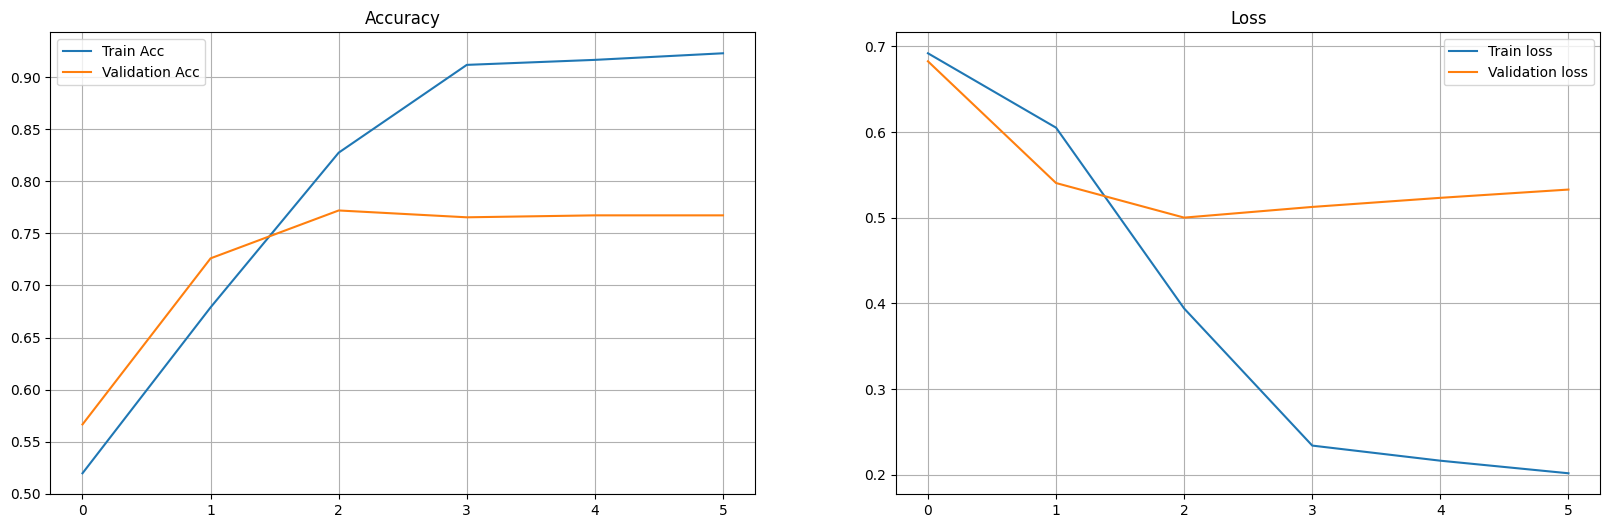

In [23]:
BiLSTM_w_attention = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=True, GRU=False)
bilstm_w_attention_loss, bilstm_w_attention_accuracy = run_model(BiLSTM_w_attention)

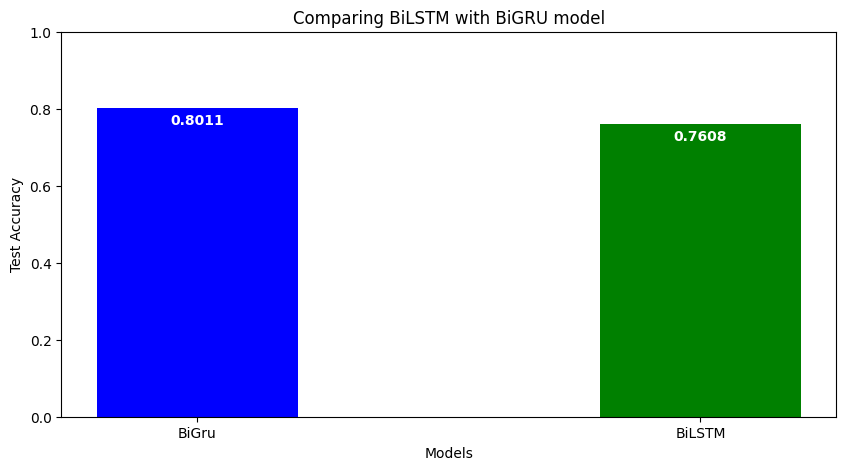

In [11]:
all_test_accuracy = {'BiGru': bigru_accuracy, 'BiLSTM': bilstm_accuracy}
labels = list(all_test_accuracy.keys())
accuracy = list(all_test_accuracy.values())

fig = plt.figure(figsize=(10,5))

bars = plt.bar(labels, accuracy, color = ['blue', 'green'], width=0.4)

# Add labels on top of each bar
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, 
             f"{acc:.4f}", ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Comparing BiLSTM with BiGRU model")
plt.ylim(0, 1) 

plt.show()

# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.
